This notebook tests the idea of feature engineering with Restricted Boltzmann Machine. 

We use the connect-4 data  from UCI repo as the example data set: https://archive.ics.uci.edu/ml/datasets/Connect-4

There are 42 attributes corresponding to the board positions in the game of connect-4. 

Each of the 42 attributes can take values: x, o, or b. See the UCI page for descrption. 

We will build two models and compare their performance. 

- The first model is a simple logistic regression built on the original data.

- In the second model, we first train a RBM and then transfrom the original data by propagating the data from the visible layer to the hidden layer. And use the hidden layer as an input to the logistic regression model. 


We will use 70%-30% train-test split and boostrap the procedure multiple times to measure the performance. 

In [13]:
# x=player x has taken, o=player o has taken, b=blank
#
# The board is numbered like  6 . . . . . . .
#                             5 . . . . . . .
#                             4 . . . . . . .
#                             3 . . . . . . .
#                             2 . . . . . . .
#                             1 . . . . . . .
#                               a b c d e f g
#                              

In [94]:
import datetime
from scipy import stats
import numpy as np
import pandas as pd

from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

import seaborn as sbn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 500)

In [47]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_fontsize)
        tick.label.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_fontsize)
        tick.label.set_rotation(y_rotation)
        

In [3]:
feature_columns = []
for horizontal in 'abcdefg':
    for vertical in '123456':
        feature_columns.append(horizontal + vertical)
columns = feature_columns + ['class']

In [4]:
raw_data = pd.read_csv('connect-4.data', header=None, names=columns)

In [5]:
raw_data.shape

(67557, 43)

In [6]:
X = pd.get_dummies(raw_data, drop_first=True, columns=feature_columns)
Y = X.pop('class')
Y = (Y == 'win').astype(np.float32)
encoded_feature_columns = X.columns

In [7]:
X.head()

,a1_o,a1_x,a2_o,a2_x,a3_o,a3_x,a4_o,a4_x,a5_o,a5_x,a6_o,a6_x,b1_o,b1_x,b2_o,b2_x,b3_o,b3_x,b4_o,b4_x,b5_o,b5_x,b6_o,b6_x,c1_o,c1_x,c2_o,c2_x,c3_o,c3_x,c4_o,c4_x,c5_o,c5_x,c6_o,c6_x,d1_o,d1_x,d2_o,d2_x,d3_o,d3_x,d4_o,d4_x,d5_o,d5_x,d6_o,d6_x,e1_o,e1_x,e2_o,e2_x,e3_o,e3_x,e4_o,e4_x,e5_o,e5_x,e6_o,e6_x,f1_o,f1_x,f2_o,f2_x,f3_o,f3_x,f4_o,f4_x,f5_o,f5_x,f6_o,f6_x,g1_o,g1_x,g2_o,g2_x,g3_o,g3_x,g4_o,g4_x,g5_o,g5_x,g6_o,g6_x
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
start_time = datetime.datetime.now()
rbm = BernoulliRBM(n_components=100, 
                   learning_rate=0.01,
                   n_iter=5000,
                   random_state=0, verbose=False)        
rbm.fit(X)
time_elapsed = datetime.datetime.now() - start_time       
print(time_elapsed)
# this may take 2 hours to run

print('pseudo-likelihood: {0:.3f}'.format(np.mean(rbm.score_samples(X))))  # -74.451
print('free energy: {0:.3f}'.format(np.mean(rbm._free_energy(X))))   # -345.379

In [109]:
n_trials = 100
records = []
plotting_data = {}
for i in range(n_trials):
    X_train, X_test, Y_train, Y_test = train_test_split(X.values, Y.values, test_size=0.3)  #, random_state=0)
    
    # train a logistic regression on the original data
    lgcv = LogisticRegressionCV(cv=5)
    lgcv.fit(X_train, Y_train)
    #idx_best_C = np.argmax(np.mean(lgcv.scores_[1.0], axis=0))
    #best_c = lgcv.Cs_[idx_best_C]

    # evaluation
    train_probas = lgcv.predict_proba(X_train)[:, 1]
    train_accuracy = np.mean(lgcv.predict(X_train) == Y_train)
    train_roc_auc = roc_auc_score(Y_train, train_probas)
    train_fpr, train_tpr, _ = roc_curve(Y_train, train_probas)
    train_average_precision = average_precision_score(Y_train, train_probas)
    train_precision, train_recall, _ = precision_recall_curve(Y_train, train_probas)

    test_probas = lgcv.predict_proba(X_test)[:, 1]
    test_accuracy = np.mean(lgcv.predict(X_test) == Y_test)
    test_roc_auc = roc_auc_score(Y_test, test_probas)
    test_fpr, test_tpr, _ = roc_curve(Y_test, test_probas)
    test_average_precision = average_precision_score(Y_test, test_probas)
    test_precision, test_recall, _ = precision_recall_curve(Y_test, test_probas)
    
    records.append(('Orig data', 'train', train_accuracy, train_roc_auc, train_average_precision))
    records.append(('Orig data', 'test', test_accuracy, test_roc_auc, test_average_precision))

    
    if i == 0:
        plotting_data['orig_data'] = {}
        plotting_data['orig_data']['train'] = {}
        plotting_data['orig_data']['train']['accuracy'] = train_accuracy
        plotting_data['orig_data']['train']['roc_auc'] = train_roc_auc                
        plotting_data['orig_data']['train']['average_precision'] = train_average_precision
        plotting_data['orig_data']['train']['fpr'] = train_fpr
        plotting_data['orig_data']['train']['tpr'] = train_tpr
        plotting_data['orig_data']['train']['precision'] = train_precision
        plotting_data['orig_data']['train']['recall'] = train_recall
    
        plotting_data['orig_data']['test'] = {}
        plotting_data['orig_data']['test']['accuracy'] = test_accuracy
        plotting_data['orig_data']['test']['roc_auc'] = test_roc_auc        
        plotting_data['orig_data']['test']['average_precision'] = test_average_precision
        plotting_data['orig_data']['test']['fpr'] = test_fpr
        plotting_data['orig_data']['test']['tpr'] = test_tpr
        plotting_data['orig_data']['test']['precision'] = test_precision
        plotting_data['orig_data']['test']['recall'] = test_recall    
    
    
    # train another logistic regression on the data with RBM transformed 
    rbm_X_train = rbm.transform(X_train)
    rbm_X_test = rbm.transform(X_test)
    
    rbm_lgcv = LogisticRegressionCV(cv=5)
    rbm_lgcv.fit(rbm_X_train, Y_train)
    #idx_best_C = np.argmax(np.mean(rbm_lgcv.scores_[1.0], axis=0))
    #best_c = rbm_lgcv.Cs_[idx_best_C]

    # evaluation
    train_probas = rbm_lgcv.predict_proba(rbm_X_train)[:, 1]
    train_accuracy = np.mean(rbm_lgcv.predict(rbm_X_train) == Y_train)
    train_roc_auc = roc_auc_score(Y_train, train_probas)
    train_fpr, train_tpr, _ = roc_curve(Y_train, train_probas)
    train_average_precision = average_precision_score(Y_train, train_probas)
    train_precision, train_recall, _ = precision_recall_curve(Y_train, train_probas)

    test_probas = rbm_lgcv.predict_proba(rbm_X_test)[:, 1]
    test_accuracy = np.mean(rbm_lgcv.predict(rbm_X_test) == Y_test)
    test_roc_auc = roc_auc_score(Y_test, test_probas)
    test_fpr, test_tpr, _ = roc_curve(Y_test, test_probas)
    test_average_precision = average_precision_score(Y_test, test_probas)
    test_precision, test_recall, _ = precision_recall_curve(Y_test, test_probas)
    
    records.append(('RBM data', 'train', train_accuracy, train_roc_auc, train_average_precision))
    records.append(('RBM data', 'test', test_accuracy, test_roc_auc, test_average_precision))
    
    
    if i == 0:
        plotting_data['rbm_data'] = {}
        plotting_data['rbm_data']['train'] = {}
        plotting_data['rbm_data']['train']['accuracy'] = train_accuracy
        plotting_data['rbm_data']['train']['roc_auc'] = train_roc_auc                
        plotting_data['rbm_data']['train']['average_precision'] = train_average_precision
        plotting_data['rbm_data']['train']['fpr'] = train_fpr
        plotting_data['rbm_data']['train']['tpr'] = train_tpr
        plotting_data['rbm_data']['train']['precision'] = train_precision
        plotting_data['rbm_data']['train']['recall'] = train_recall
    
        plotting_data['rbm_data']['test'] = {}
        plotting_data['rbm_data']['test']['accuracy'] = test_accuracy
        plotting_data['rbm_data']['test']['roc_auc'] = test_roc_auc        
        plotting_data['rbm_data']['test']['average_precision'] = test_average_precision
        plotting_data['rbm_data']['test']['fpr'] = test_fpr
        plotting_data['rbm_data']['test']['tpr'] = test_tpr
        plotting_data['rbm_data']['test']['precision'] = test_precision
        plotting_data['rbm_data']['test']['recall'] = test_recall    
    
records = pd.DataFrame(records, columns=['data_type', 'split_type', 'accuracy', 'roc_auc', 'ave_P'])


Below show the results (accuracy, ROC AUC, precision, recall, and average precision) from one particular run, which show that RBM doesn't necessarily improve the model performance.

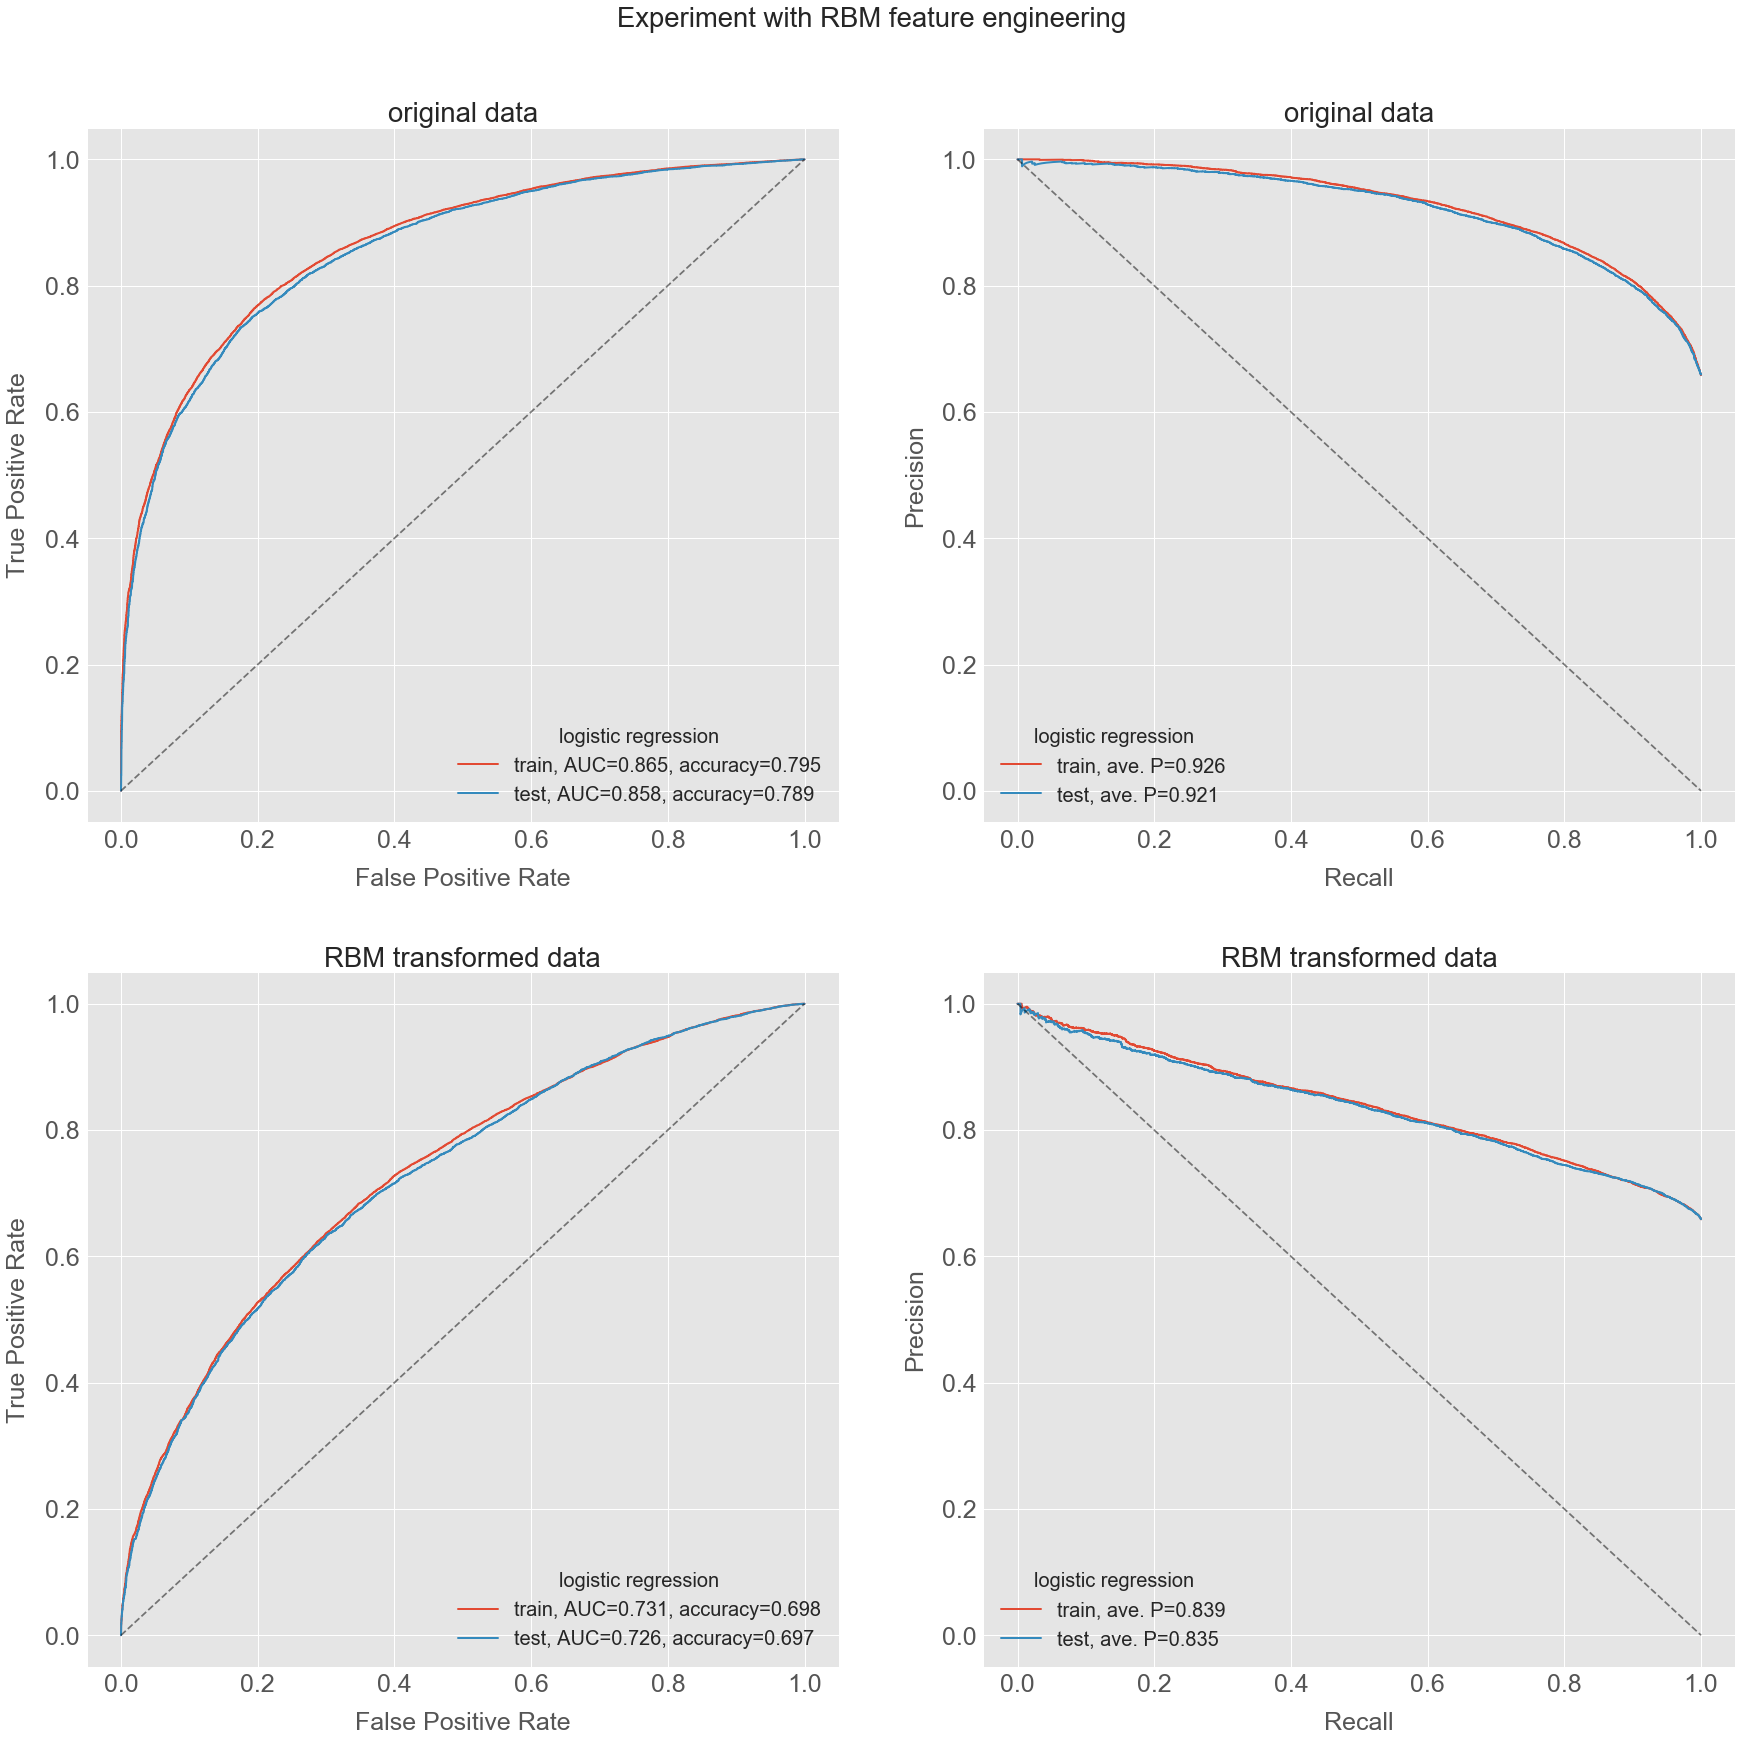

In [110]:
FONTSIZE = 25
fig = plt.figure(figsize=(24, 24))  # horizontal, vertical
gs = matplotlib.gridspec.GridSpec(2, 2)  # vertical, horizontal

### original data ###
# True Positive Rate versus False Positive Rate
ax = plt.subplot(gs[0, 0])
train_p1, = ax.plot(plotting_data['orig_data']['train']['fpr'], 
                    plotting_data['orig_data']['train']['tpr'], 
                    lw=2, markersize=0, label='train')
test_p1, = ax.plot(plotting_data['orig_data']['test']['fpr'], 
                    plotting_data['orig_data']['test']['tpr'], 
                    lw=2, markersize=0, label='test')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.set_xlabel('False Positive Rate', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('True Positive Rate', fontsize=FONTSIZE, labelpad=15)
l = ax.legend([train_p1, test_p1], 
              ['train, AUC={0:.3f}, accuracy={1:.3f}'.format(plotting_data['orig_data']['train']['roc_auc'], 
                                                             plotting_data['orig_data']['train']['accuracy']),
               'test, AUC={0:.3f}, accuracy={1:.3f}'.format(plotting_data['orig_data']['test']['roc_auc'], 
                                                             plotting_data['orig_data']['test']['accuracy'])
              ],
               title='logistic regression',
               fontsize=0.8*FONTSIZE, loc=4)
plt.setp(l.get_title(), fontsize=0.8*FONTSIZE)
ax.set_title('original data', fontsize=1.1*FONTSIZE)


# Precision versus recall
ax = plt.subplot(gs[0, 1])
train_p2, = ax.plot(plotting_data['orig_data']['train']['recall'], 
                    plotting_data['orig_data']['train']['precision'], 
                    lw=2, markersize=0, label='train')
test_p2, = ax.plot(plotting_data['orig_data']['test']['recall'], 
                    plotting_data['orig_data']['test']['precision'], 
                    lw=2, markersize=0, label='test')
ax.plot([0, 1], [1, 0], 'k--', alpha=0.5)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.set_xlabel('Recall', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('Precision', fontsize=FONTSIZE, labelpad=15)
l = ax.legend([train_p2, test_p2], 
              ['train, ave. P={0:.3f}'.format(plotting_data['orig_data']['train']['average_precision']),
               'test, ave. P={0:.3f}'.format(plotting_data['orig_data']['test']['average_precision'])
              ],
               title='logistic regression',
               fontsize=0.8*FONTSIZE, loc=3)
plt.setp(l.get_title(), fontsize=0.8*FONTSIZE)
ax.set_title('original data', fontsize=1.1*FONTSIZE)


### data with RBM transformation ###
# True Positive Rate versus False Positive Rate
ax = plt.subplot(gs[1, 0])
train_p3, = ax.plot(plotting_data['rbm_data']['train']['fpr'], 
                    plotting_data['rbm_data']['train']['tpr'], 
                    lw=2, markersize=0, label='train')
test_p3, = ax.plot(plotting_data['rbm_data']['test']['fpr'], 
                    plotting_data['rbm_data']['test']['tpr'], 
                    lw=2, markersize=0, label='test')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.set_xlabel('False Positive Rate', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('True Positive Rate', fontsize=FONTSIZE, labelpad=15)
l = ax.legend([train_p3, test_p3], 
              ['train, AUC={0:.3f}, accuracy={1:.3f}'.format(plotting_data['rbm_data']['train']['roc_auc'], 
                                                             plotting_data['rbm_data']['train']['accuracy']),
               'test, AUC={0:.3f}, accuracy={1:.3f}'.format(plotting_data['rbm_data']['test']['roc_auc'], 
                                                             plotting_data['rbm_data']['test']['accuracy'])
              ],
               title='logistic regression',
               fontsize=0.8*FONTSIZE, loc=4)
plt.setp(l.get_title(), fontsize=0.8*FONTSIZE)
ax.set_title('RBM transformed data', fontsize=1.1*FONTSIZE)


# Precision versus recall
ax = plt.subplot(gs[1, 1])
train_p4, = ax.plot(plotting_data['rbm_data']['train']['recall'], 
                    plotting_data['rbm_data']['train']['precision'], 
                    lw=2, markersize=0, label='train')
test_p4, = ax.plot(plotting_data['rbm_data']['test']['recall'], 
                    plotting_data['rbm_data']['test']['precision'], 
                    lw=2, markersize=0, label='test')
ax.plot([0, 1], [1, 0], 'k--', alpha=0.5)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.set_xlabel('Recall', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('Precision', fontsize=FONTSIZE, labelpad=15)
l = ax.legend([train_p4, test_p4], 
              ['train, ave. P={0:.3f}'.format(plotting_data['rbm_data']['train']['average_precision']),
               'test, ave. P={0:.3f}'.format(plotting_data['rbm_data']['test']['average_precision'])
              ],
               title='logistic regression',
               fontsize=0.8*FONTSIZE, loc=3)
plt.setp(l.get_title(), fontsize=0.8*FONTSIZE)
ax.set_title('RBM transformed data', fontsize=1.1*FONTSIZE)


# ---------------------- #
st = fig.suptitle('Experiment with RBM feature engineering', fontsize=1.1*FONTSIZE)
plt.tight_layout(pad=0, w_pad=6.5, h_pad=6.5)
st.set_y(1.0)
fig.subplots_adjust(top=0.93)

In [111]:
def checkTTest(df):
    test_results = {}
    metrics = ['accuracy', 'roc_auc', 'ave_P']
    for m in metrics:
        a = df[df['data_type'] == 'Orig data'][m]
        b = df[df['data_type'] == 'RBM data'][m]
        statistics, pvalue = stats.ttest_ind(a, b)
        test_results[m] = (statistics, pvalue)
    return test_results

The box plots below then summarize the results from all the simulations run above. Which clearly indicate that RBM doesn't improve the performance for this particular dataset.

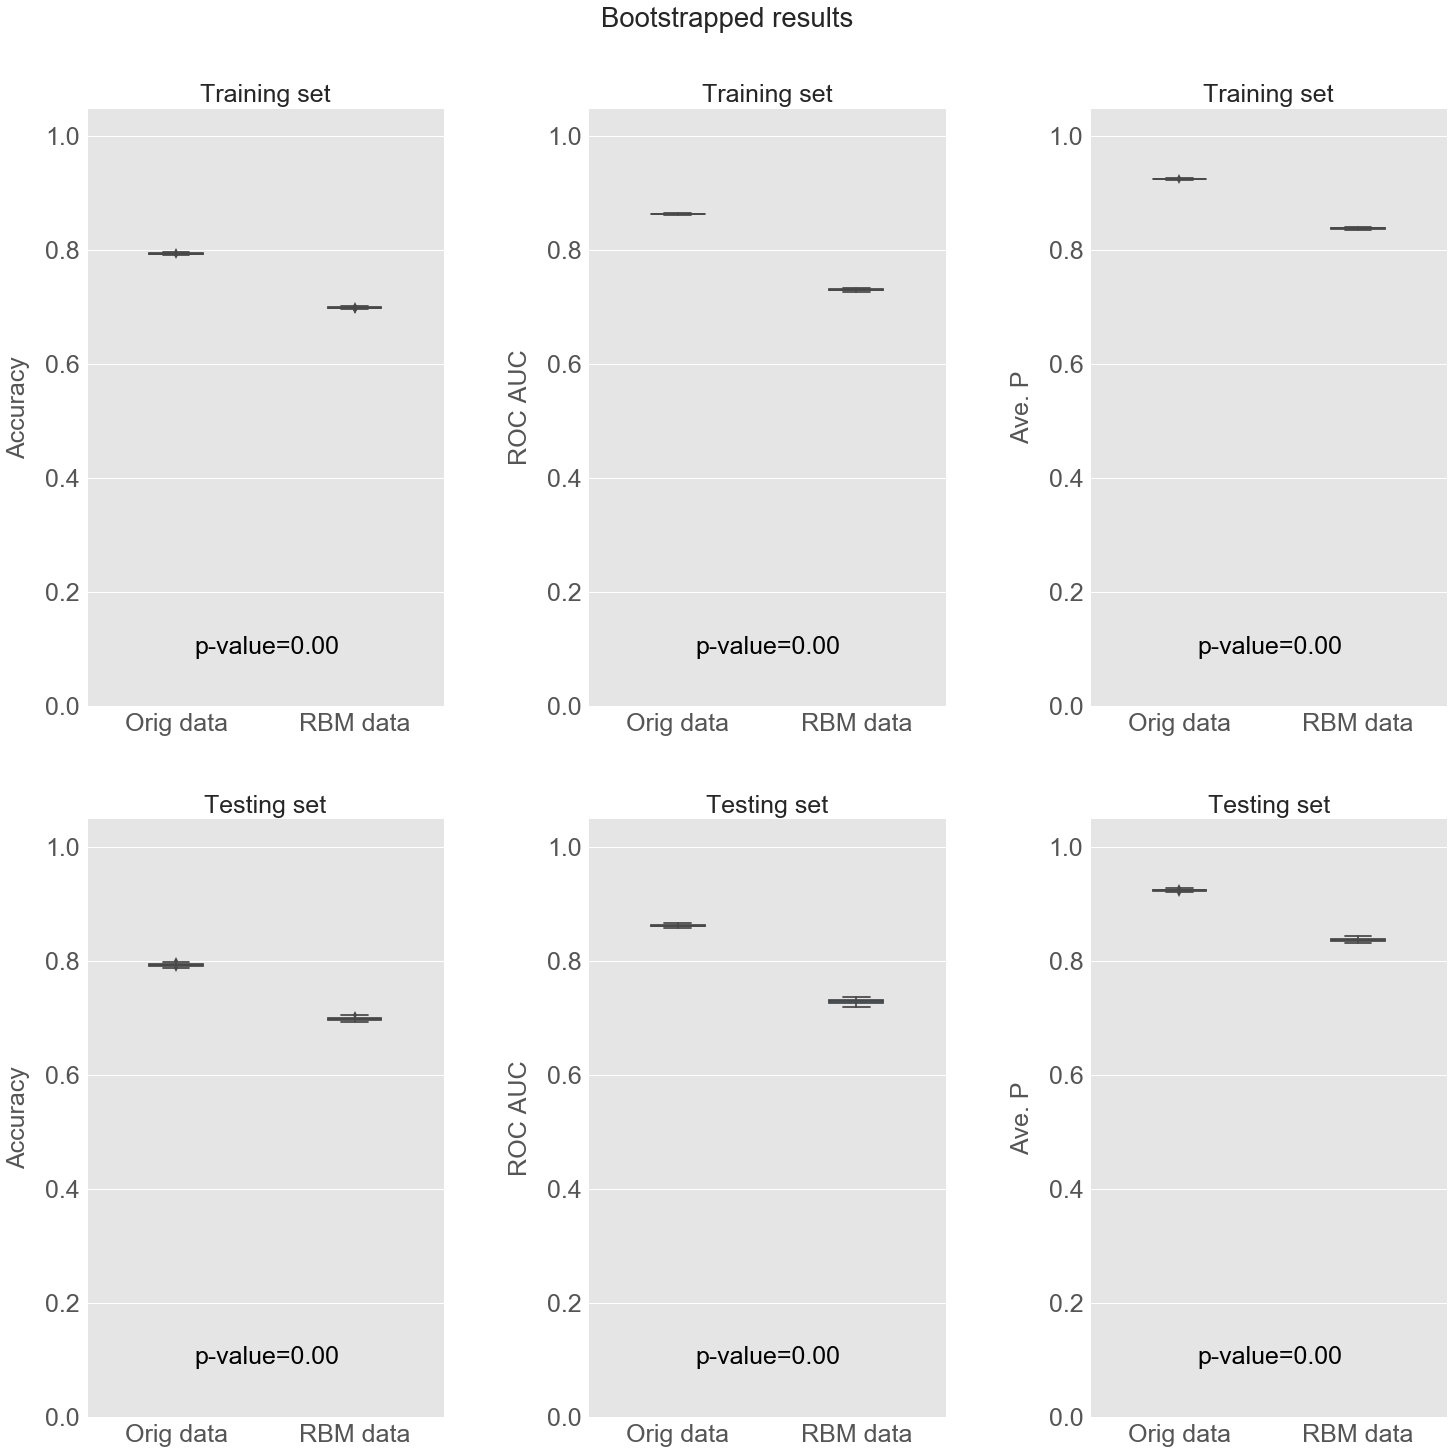

In [113]:
FONTSIZE = 25
fig = plt.figure(figsize=(20, 20))  # horizontal, vertical
gs = matplotlib.gridspec.GridSpec(2, 3)  # vertical, horizontal

split_type = ['train', 'test']
texts = ['Training', 'Testing']
# original data
for i in range(2):
        
    df = records[(records['split_type'] == split_type[i])]
    test_results = checkTTest(df)
    

    ax = plt.subplot(gs[i, 0])
    ax = sbn.boxplot(x='data_type', y='accuracy', data=df, ax=ax, width=0.3)
    #ax = sbn.stripplot(x='data_type', y='accuracy', data=df, ax=ax, alpha=0.5, color='black', jitter=True)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('', fontsize=0, labelpad=5)
    ax.set_ylabel('Accuracy', fontsize=FONTSIZE, labelpad=15)
    ax.set_title('{0:} set'.format(texts[i]), fontsize=FONTSIZE)
    adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)    
    ax.text(0.3, 0.08, 'p-value={0:.2f}'.format(test_results['accuracy'][1]),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            color='k', fontsize=FONTSIZE)

    
    ax = plt.subplot(gs[i, 1])
    ax = sbn.boxplot(x='data_type', y='roc_auc', data=df, ax=ax, width=0.3)
    #ax = sbn.stripplot(x='data_type', y='roc_auc', data=df, ax=ax, alpha=0.5, color='black', jitter=True)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('', fontsize=0, labelpad=5)
    ax.set_ylabel('ROC AUC', fontsize=FONTSIZE, labelpad=15)
    ax.set_title('{0:} set'.format(texts[i]), fontsize=FONTSIZE)
    adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
    ax.text(0.3, 0.08, 'p-value={0:.2f}'.format(test_results['roc_auc'][1]),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            color='k', fontsize=FONTSIZE)

    
    ax = plt.subplot(gs[i, 2])
    ax = sbn.boxplot(x='data_type', y='ave_P', data=df, ax=ax, width=0.3)
    #ax = sbn.stripplot(x='data_type', y='ave_P', data=df, ax=ax, alpha=0.5, color='black', jitter=True)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('', fontsize=0, labelpad=5)
    ax.set_ylabel('Ave. P', fontsize=FONTSIZE, labelpad=15)
    ax.set_title('{0:} set'.format(texts[i]), fontsize=FONTSIZE)
    adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
    ax.text(0.3, 0.08, 'p-value={0:.2f}'.format(test_results['ave_P'][1]),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            color='k', fontsize=FONTSIZE)


# ---------------------- #
st = fig.suptitle('Bootstrapped results', fontsize=1.1*FONTSIZE)
plt.tight_layout(pad=0, w_pad=6.5, h_pad=6.5)
st.set_y(1.0)
fig.subplots_adjust(top=0.93)